# Instructional Notebook: Portfolio Optimization with Python (U.S. Market Version)

***Author: José Luis Cruz Balderas, CFA***

### Important Note and Disclaimer

- The content of this notebook is presented for **purely educational and technical demonstration purposes.** The information and code provided here **do not constitute financial advice, an investment recommendation, or an offer to buy or sell any financial asset.**

- This material is provided "as is," without any guarantee of accuracy, completeness, or timeliness. The code was developed using specific versions of Python libraries at the time of its creation; its proper functioning in the future may require adaptations due to updates in said libraries. The author reserves the right to **make modifications** to this notebook at his sole discretion.

- As a public document, **the author is not responsible for the use, interpretation, or consequences arising from the application that third parties may give to the information or code presented here.** Artificial Intelligence tools were used to support the writing and structuring of this material; all content has been carefully supervised, validated, and corrected by the author to ensure its reliability and coherence with financial theory and practice.

- The analyses are based on **historical data**, and it is crucial to remember that **past performance is not a reliable indicator of future results.** Financial markets are inherently volatile and unpredictable. It is strongly recommended that you consult a professional financial advisor before making any investment decisions.

## Introduction: The Investor's Dilemma

Every investor, from the novice to the most experienced, faces the same fundamental dilemma: **How can I get the highest possible return for a level of risk I am willing to accept?**

For decades, the answer was more of an art than a science. It was based on intuition, selecting "winning" stocks, and the vague idea that "you shouldn't put all your eggs in one basket."

Everything changed in 1952. A young economist named **Harry Markowitz** published a paper that transformed investing into a science. He mathematically demonstrated that a portfolio's risk does not depend on individual assets, but on how they relate to each other. He gave us the tools to accurately measure and manage risk. For this work, he would win the Nobel Prize.

**What will you do in this notebook?**

In this interactive tutorial, you will follow in Markowitz's footsteps. You will learn to use Python and its powerful libraries to:

1. Build a portfolio of assets.

2. Calculate its expected risk and return.

3. Find the **Efficient Frontier**: the set of all portfolios that offer the best risk-return trade-off.

4. Identify the **Optimal Portfolio**: the portfolio that, according to theory, offers the best possible balance between risk and return.

By the end, you will not only have created a sophisticated optimization model, but you will also deeply understand the principles that govern modern investment.

**Let's begin!**

## Phase 0: Environment Setup

Before we dive into the analysis, we need to ensure our Python environment has all the necessary tools. The following code cell uses **`pip`**, Python's package manager, to install all the libraries we will use in this project.

 - *If this is your first time running this notebook, simply execute the cell below.*

 - *If you already have the libraries installed, you can skip this step.*

In [1]:
# The '!' symbol tells Jupyter to run the command in the system terminal.
# The '-q' (quiet) parameter makes the installation less noisy, showing less text.
!pip install yfinance pandas numpy matplotlib seaborn scipy -q

print("Environment configured. All necessary libraries are installed.")

Environment configured. All necessary libraries are installed.


## Phase 1: Data Preparation and Analysis

Welcome! In this first phase of our analysis, we will lay the groundwork for our project. The objective is simple but crucial: to obtain the historical data of our selected assets and process it to get the two fundamental ingredients that Harry Markowitz taught us to use:

1. The **Expected Return** of each asset.

2. The **Covariance** between them, which measures how they move together.

Let's get started.

### Step 1.1: Importing Libraries

Once the environment is set up, we proceed to import the libraries we will use. Grouping all imports at the beginning of the script is a good practice. Each one is like a specialist on our team:

* **`yfinance`**: Our personal stockbroker. It will go to Yahoo! Finance and fetch the price data we request.

* **`pandas`**: The master of spreadsheets in Python. We will use it to organize our data into tables (DataFrames).

* **`numpy`**: The math genius. It will handle complex numerical calculations efficiently.

* **`datetime`**: To manage the dates for our analysis.

* **`matplotlib` / `seaborn`**: Our graphic artists. They will be in charge of creating the visualizations of the Efficient Frontier.

* **`scipy`**: Our mathematical optimizer. We will use it to find the optimal portfolios precisely.

In [2]:
# --- Data analysis libraries ---
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
from scipy.optimize import minimize

# --- Visualization libraries ---
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter # We import the percentage formatter

print("Libraries imported successfully.")

Libraries imported successfully.


### Step 1.2: Asset Selection and Analysis Period

For this analysis, we will focus on the U.S. market, selecting a set of well-known large-cap stocks from different sectors to ensure good diversification. This allows us to apply the same robust methodology to a different market, demonstrating the versatility of the model.

* **Apple (AAPL):** Represents the Technology sector, a key driver of growth.

* **JPMorgan Chase (JPM):** Represents the Financial sector, crucial to the economic cycle.

* **Johnson & Johnson (JNJ):** Represents the defensive Healthcare sector.

* **Exxon Mobil (XOM):** Represents the cyclical Energy sector.

* **SPDR S&P 500 ETF (SPY):** Acts as a benchmark and a broadly diversified anchor for the portfolio.

For the analysis, we have defined a time window of **5 years**. The code is designed to be dynamic: when executed, it will automatically retrieve data for the last five years from the current date. This ensures that our sample is always recent and includes different market conditions. If you wish to analyze a specific historical period, the `start_date` and `end_date` variables in the following code block can be easily modified.

In [3]:
# Universe of assets: 5 well-known US stocks for diversification
tickers = ['AAPL', 'JPM', 'JNJ', 'XOM', 'SPY']

# We define the 5-year period
end_date = datetime.now()
start_date = end_date - pd.DateOffset(years=5)

print(f"Assets to analyze: {tickers}")
print(f"Analysis period: From {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")

Assets to analyze: ['AAPL', 'JPM', 'JNJ', 'XOM', 'SPY']
Analysis period: From 2020-09-01 to 2025-09-01


### Step 1.3: Data Download and Cleaning

Now we ask `yfinance` to bring us the adjusted closing prices (`Adj Close`). We use the adjusted price because it already takes into account events like dividend payments, giving us a more accurate measure of the actual return for the investor.

>**Technical Note:** We include the parameter `auto_adjust=False`. By default, the `yfinance` library now adjusts all prices and removes the `Adj Close` column. By specifying `auto_adjust=False`, we ask it to maintain the previous behavior and give us the `Adj Close` column separately, which is what we will use for our calculations.

Once downloaded, it is good practice to check for missing data. Market data is recorded only on **trading days**, so we will not have information for **weekends** or **holidays**. Additionally, missing data (`NaN`) can occur if one market was closed on a holiday that another was not. We will show the sum of `NaNs` before and after cleaning to confirm that our process was successful.

In [4]:
# We download the adjusted closing prices, specifying auto_adjust=False
prices = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)['Adj Close']

# We check for missing data for each asset BEFORE cleaning
print("Checking for missing data BEFORE cleaning:")
print(prices.isna().sum())

# We remove any rows with missing data to maintain the integrity of the analysis
clean_prices = prices.dropna()

# We verify that there is no more missing data AFTER cleaning
print("\nChecking for missing data AFTER cleaning:")
print(clean_prices.isna().sum())

# We display the first 5 records to verify the data structure
print("\nPreview of downloaded and cleaned prices:")
clean_prices.head()

[*********************100%***********************]  5 of 5 completed

Checking for missing data BEFORE cleaning:
Ticker
AAPL    0
JNJ     0
JPM     0
SPY     0
XOM     0
dtype: int64

Checking for missing data AFTER cleaning:
Ticker
AAPL    0
JNJ     0
JPM     0
SPY     0
XOM     0
dtype: int64

Preview of downloaded and cleaned prices:


Ticker,AAPL,JNJ,JPM,SPY,XOM
Date,,,,,
2020-09-01,130.519287,131.378769,87.565376,328.312256,31.742571
2020-09-02,127.815140,133.381714,88.885765,333.060944,31.549368
2020-09-03,117.582100,129.670670,88.605965,321.598877,31.484955
2020-09-04,117.659943,128.838257,90.520958,318.973145,31.460814
2020-09-08,109.742012,127.685089,87.373001,310.257874,30.736279


### Step 1.4: Calculating Returns

Prices alone do not tell us much about performance. We need to calculate the **daily returns**. We will use **logarithmic returns**, a standard practice in quantitative finance because they have very convenient statistical properties (like additivity over time).

The formula is: `ln(Today's Price / Yesterday's Price)`

In [7]:
# We calculate the daily logarithmic returns
returns = np.log(clean_prices / clean_prices.shift(1))

# The first day will have no return, so we remove that row
returns = returns.dropna()

# We display the first 5 records of the returns
print("Preview of daily logarithmic returns:")
returns.head()

Preview of daily logarithmic returns:


Ticker,AAPL,JNJ,JPM,SPY,XOM
Date,,,,,
2020-09-02,-0.020936,0.015131,0.014966,0.014360,-0.006105
2020-09-03,-0.083448,-0.028217,-0.003153,-0.035020,-0.002044
2020-09-04,0.000662,-0.006440,0.021382,-0.008198,-0.000767
2020-09-08,-0.069666,-0.008991,-0.035395,-0.027703,-0.023299
2020-09-09,0.039112,0.016433,0.009463,0.019555,-0.006042


### Step 1.5: Calculating Annualized Metrics

Finally, we take our daily data and project it to an annual horizon, which is more useful for investment decision-making.

* **Mean Annualized Returns:** The average return we could expect in a year. We calculate it by multiplying the average daily return by 252 (the approximate number of trading days in a year).

* **Annualized Covariance Matrix:** This is the centerpiece. It tells us not only the risk of each asset (on the diagonal) but also how each asset moves in relation to the others.

In [9]:
# We calculate the vector of mean annualized returns
mean_annual_returns = returns.mean() * 252

# We calculate the annualized covariance matrix
annual_covariance_matrix = returns.cov() * 252

print("\n--- Analysis Completed! ---")
print("\nMean Annualized Returns (Our 'Expected Return'):")
print(mean_annual_returns)

print("\nAnnualized Covariance Matrix (Our 'Risk and Correlation'):")
annual_covariance_matrix


--- Analysis Completed! ---

Mean Annualized Returns (Our 'Expected Return'):
Ticker
AAPL    0.115715
JNJ     0.060091
JPM     0.248407
SPY     0.135719
XOM     0.257442
dtype: float64

Annualized Covariance Matrix (Our 'Risk and Correlation'):


Ticker,AAPL,JNJ,JPM,SPY,XOM
Ticker,,,,,
AAPL,0.085036,0.008835,0.024101,0.038930,0.015345
JNJ,0.008835,0.028811,0.009783,0.007830,0.007979
JPM,0.024101,0.009783,0.064054,0.027258,0.030851
SPY,0.038930,0.007830,0.027258,0.030638,0.018173
XOM,0.015345,0.007979,0.030851,0.018173,0.083707


And that's it! We have completed the first phase. We now have the two essential ingredients to apply Markowitz's theory. In the next phase, we will use these results to simulate thousands of portfolios and start looking for our Efficient Frontier.

## Phase 2: Monte Carlo Simulation

With our data ready, we can now start building portfolios. But what is the best combination of our 5 assets? Should we invest 20% in each? Or 50% in one and 12.5% in the others? The combinations are endless.

To explore this universe of possibilities, we will use a technique called **Monte Carlo Simulation**. The idea is simple: we will generate thousands of portfolios with random weights, calculate the risk and return for each, and then plot them. The result will be a 'cloud' of points that will visually show us the relationship between risk and return.

### Step 2.1: Defining the Risk-Free Rate

To calculate the **Sharpe Ratio**, a key metric, we need a benchmark: the **risk-free rate**. For an analysis based on the U.S. market, the standard approximation is the yield on short-term **U.S. Treasury Bills (T-Bills)**.

> **Recommended action:** Before running, search on Google for the "3-month US Treasury Bill rate" and update the `risk_free_rate` variable with the most recent value (expressed as a decimal).

In [11]:
# 3-month US T-Bill rate
# It is important to update this value for an accurate analysis.
risk_free_rate = 0.0415

print(f"Risk-free rate set at: {risk_free_rate:.2%}")

Risk-free rate set at: 4.15%


### Step 2.2: Portfolio Simulation

Now, let's generate 20,000 different portfolios. For each one, we will do the following:

- We will assign random weights to each asset.

- We will ensure that the sum of the weights is 1 (i.e., 100% of our capital).

- We will calculate the portfolio's return, volatility, and Sharpe Ratio.

**Sharpe Ratio Formula:**
(Portfolio Return - Risk-Free Rate) / Portfolio Volatility

In [12]:
# --- Simulation Setup ---
# Define the total number of random portfolios we are going to generate.
# A larger number will give us a denser "cloud" of points and a better visual approximation.
num_portfolios = 20000

# --- Preparing to store results ---
# We create an empty "canvas" using NumPy to store the results efficiently.
# It will have 3 rows (for Return, Volatility, Sharpe Ratio) and one column for each portfolio.
results = np.zeros((3, num_portfolios))

# We create an empty list where we will store the weight combinations of each portfolio.
weights_list = []

# --- Monte Carlo Simulation Loop ---
# This loop will repeat 'num_portfolios' times. In each iteration, it will create a unique portfolio.
for i in range(num_portfolios):
    # Generates a set of random numbers, one for each asset in our portfolio.
    weights = np.random.random(len(tickers))
    
    # Normalizes the random numbers so that their sum is exactly 1 (100% of the investment).
    weights /= np.sum(weights)
    
    # Saves the valid weight combination in our list.
    weights_list.append(weights)
    
    # --- Calculation of the current portfolio's metrics ---
    portfolio_return = np.sum(mean_annual_returns * weights)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(annual_covariance_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    
    # --- Storage of the current portfolio's results ---
    results[0,i] = portfolio_return
    results[1,i] = portfolio_volatility
    results[2,i] = sharpe_ratio

# --- Convert results to a Pandas DataFrame for easy handling ---
results_dict = {
    'Return': results[0],
    'Volatility': results[1],
    'SharpeRatio': results[2]
}

for i, ticker in enumerate(tickers):
    results_dict[f'Weight_{ticker}'] = [p[i] for p in weights_list]

simulated_portfolios = pd.DataFrame(results_dict)

print("Simulation completed. Preview of the results:")
simulated_portfolios.head()

Simulation completed. Preview of the results:


,Return,Volatility,SharpeRatio,Weight_AAPL,Weight_JPM,Weight_JNJ,Weight_XOM,Weight_SPY
0,0.127310,0.166609,0.515038,0.328382,0.265820,0.005933,0.255316,0.144548
1,0.183466,0.177469,0.799950,0.218092,0.116492,0.235286,0.147469,0.282661
2,0.151891,0.218434,0.505372,0.561100,0.030251,0.254052,0.145929,0.008669
3,0.174691,0.170824,0.779701,0.030659,0.273569,0.067467,0.195580,0.432725
4,0.168718,0.161559,0.787442,0.013199,0.197318,0.063546,0.388898,0.337039


### Step 2.3: Visualizing the Efficient Frontier

Now, let's plot the results. Each point on the chart will represent one of the 20,000 portfolios we simulated.

- **X-axis:** Volatility (Risk)

- **Y-axis:** Return

- **Color:** Sharpe Ratio (warmer colors will indicate a better risk-adjusted return)

The "umbrella" or hyperbola shape that the points form is the famous **Efficient Frontier**. The portfolios on the upper-left edge of the cloud are the 'efficient' ones: they offer the highest return for a given level of risk.

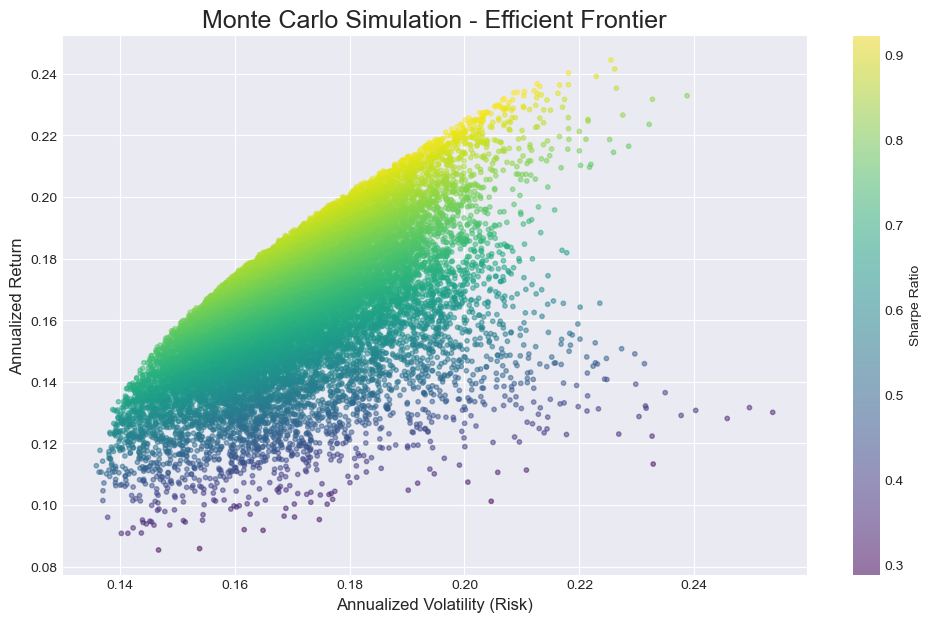

In [13]:
# --- Simulation Plot ---
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(12, 7))

plt.scatter(simulated_portfolios['Volatility'], 
            simulated_portfolios['Return'], 
            c=simulated_portfolios['SharpeRatio'], 
            cmap='viridis', 
            marker='o',
            s=10, 
            alpha=0.5)

plt.colorbar(label='Sharpe Ratio')
plt.title('Monte Carlo Simulation - Efficient Frontier', fontsize=18)
plt.xlabel('Annualized Volatility (Risk)', fontsize=12)
plt.ylabel('Annualized Return', fontsize=12)
plt.grid(True)
plt.show()

### Step 2.4: Identifying the Key Portfolios from the Simulation

The simulation gives us an excellent visual idea, but it is an approximation based on randomness. Before moving on to precise mathematical optimization, we can identify the best portfolios that our simulation managed to find.

We will look for two specific portfolios in our results:

1. **Maximum Sharpe Ratio Portfolio:** The one that offered the best return for each unit of risk.

2. **Minimum Variance (or Volatility) Portfolio:** The safest possible portfolio that was generated.

In [16]:
# --- Locate the optimal portfolios from the SIMULATION ---
max_sharpe_portfolio = simulated_portfolios.loc[simulated_portfolios['SharpeRatio'].idxmax()]
min_vol_portfolio = simulated_portfolios.loc[simulated_portfolios['Volatility'].idxmin()]

print("--- Optimal Portfolios (from simulation) ---")
print("\nMaximum Sharpe Ratio Portfolio:")
print(max_sharpe_portfolio)
print("\nMinimum Volatility Portfolio:")
print(min_vol_portfolio)

--- Optimal Portfolios (from simulation) ---

Maximum Sharpe Ratio Portfolio:
Return         0.233814
Volatility     0.208574
SharpeRatio    0.922042
Weight_AAPL    0.013213
Weight_JPM     0.040453
Weight_JNJ     0.490040
Weight_XOM     0.076766
Weight_SPY     0.379529
Name: 16791, dtype: float64

Minimum Volatility Portfolio:
Return         0.112750
Volatility     0.135949
SharpeRatio    0.524096
Weight_AAPL    0.002151
Weight_JPM     0.436562
Weight_JNJ     0.006308
Weight_XOM     0.477922
Weight_SPY     0.077057
Name: 5449, dtype: float64


### Step 2.5: Intermediate Visualization with Simulated Portfolios

Now, let's repeat our graph, but this time we will highlight the two portfolios we just found. We will use large, brightly colored stars to make them easy to identify.

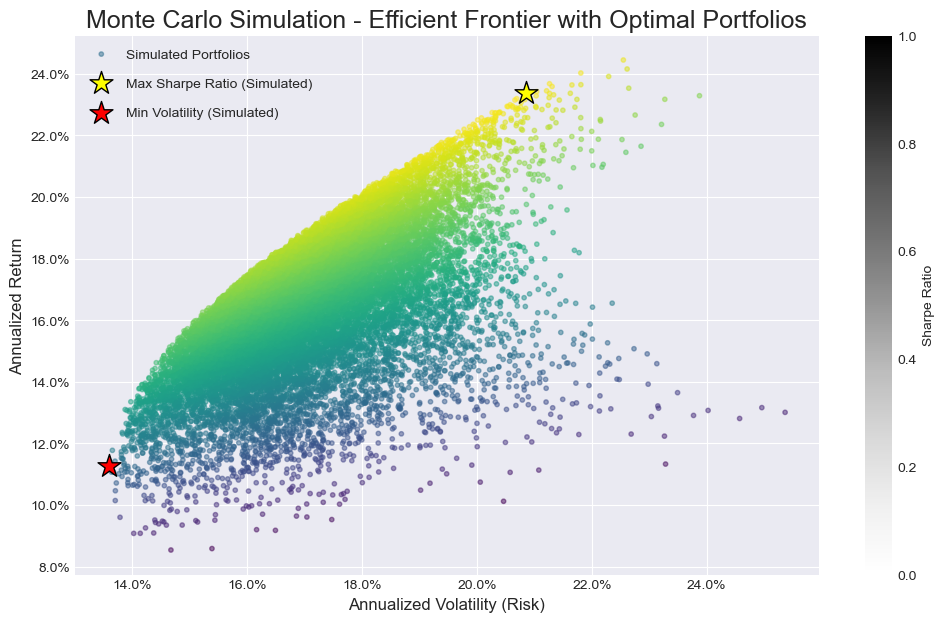

In [17]:
# --- Final Plot with Optimal Portfolios ---
plt.figure(figsize=(12, 7))

plt.scatter(simulated_portfolios['Volatility'], 
            simulated_portfolios['Return'], 
            c=simulated_portfolios['SharpeRatio'], 
            cmap='viridis', 
            marker='o',
            s=10, 
            alpha=0.5,
            label='Simulated Portfolios')

plt.scatter(max_sharpe_portfolio['Volatility'], 
            max_sharpe_portfolio['Return'], 
            marker='*', 
            color='yellow', 
            s=300, 
            edgecolors='black',
            label='Max Sharpe Ratio (Simulated)')

plt.scatter(min_vol_portfolio['Volatility'], 
            min_vol_portfolio['Return'], 
            marker='*', 
            color='red', 
            s=300,
            edgecolors='black',
            label='Min Volatility (Simulated)')

# --- Format Axes to Percentage ---
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.colorbar(label='Sharpe Ratio')
plt.title('Monte Carlo Simulation - Efficient Frontier with Optimal Portfolios', fontsize=18)
plt.xlabel('Annualized Volatility (Risk)', fontsize=12)
plt.ylabel('Annualized Return', fontsize=12)
plt.legend(labelspacing=1.2)
plt.grid(True)

plt.show()

Congratulations! You have completed the first part of Phase 2. Not only have you visualized the universe of investment possibilities with your assets, but you have also identified the two most important portfolios that our simulation found.

In the next step, we will use a mathematical optimizer to find the exact values of these portfolios, instead of relying on the luck of our simulation

## Phase 3: Mathematical Optimization and the Efficient Frontier

The simulation is powerful, but it's like looking for a needle in a haystack by randomly throwing magnets. To find the exact needle, we need a metal detector. Our detector is the `scipy.optimize` optimizer.

In this phase, we will do three things:

1. Find the **two "anchor" portfolios** of the frontier: the Minimum Volatility and the Maximum Sharpe Ratio.

2. **Plot the complete curve** of the Efficient Frontier to visualize all optimal options.

3. Calculate a **custom portfolio** based on a target risk level.

### Step 3.1: Defining Functions for the Optimizer

First, we create helper functions that, given a set of weights, will return the portfolio's metrics. This keeps our code clean and reusable. We will give the optimizer an objective (to maximize the Sharpe Ratio or minimize volatility) and a set of constraints (the weights must sum to 100%).

In [18]:
def get_portfolio_metrics(weights):
    """
    Calculates the return, volatility, and sharpe ratio of a portfolio.
    """
    ret = np.sum(mean_annual_returns * weights)
    vol = np.sqrt(np.dot(weights.T, np.dot(annual_covariance_matrix, weights)))
    sharpe = (ret - risk_free_rate) / vol
    return np.array([ret, vol, sharpe])

# Objective functions for the optimizer
# Note: To maximize the Sharpe Ratio, we minimize its negative.
def neg_sharpe_ratio(weights):
    return -get_portfolio_metrics(weights)[2]

def portfolio_volatility(weights):
    return get_portfolio_metrics(weights)[1]

### Step 3.2: Calculating the Anchor Portfolios

Now we set up the rules (constraints) and ask `scipy` to find the exact weights for our two key portfolios.

In [20]:
# Constraints and bounds for the optimizer
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for asset in range(len(tickers)))
initial_weights = len(tickers) * [1. / len(tickers),]

# --- Optimization for Maximum Sharpe Ratio ---
sharpe_solution = minimize(neg_sharpe_ratio, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

# --- Optimization for Minimum Volatility ---
volatility_solution = minimize(portfolio_volatility, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

# --- Extraction of Results ---
sharpe_weights = sharpe_solution.x
sharpe_metrics = get_portfolio_metrics(sharpe_weights)

vol_weights = volatility_solution.x
vol_metrics = get_portfolio_metrics(vol_weights)

# --- Feedback for the user ---
print("--- Anchor Portfolios Calculated ---")
print("\nMaximum Sharpe Ratio Portfolio (Optimized):")
for i, ticker in enumerate(tickers):
    print(f"  Weight {ticker}: {sharpe_weights[i]:.2%}")

print("\nMinimum Volatility Portfolio (Optimized):")
for i, ticker in enumerate(tickers):
    print(f"  Weight {ticker}: {vol_weights[i]:.2%}")

--- Anchor Portfolios Calculated ---

Maximum Sharpe Ratio Portfolio (Optimized):
  Weight AAPL: 0.00%
  Weight JPM: 0.00%
  Weight JNJ: 58.86%
  Weight XOM: 0.00%
  Weight SPY: 41.14%

Minimum Volatility Portfolio (Optimized):
  Weight AAPL: 0.00%
  Weight JPM: 49.89%
  Weight JNJ: 0.00%
  Weight XOM: 42.17%
  Weight SPY: 7.95%


### Step 3.3: Plotting the Efficient Frontier

Now for the most elegant part. To plot the frontier curve, we will ask the optimizer to find the portfolio that **minimizes risk for a range of possible returns**.

In [21]:
# --- Plotting the Efficient Frontier Curve ---
frontier_y = np.linspace(vol_metrics[0], sharpe_metrics[0]*1.1, 50) # Range of returns
frontier_x = []

def minimize_volatility_for_return(weights):
    return get_portfolio_metrics(weights)[1]

for possible_return in frontier_y:
    # Constraints: sum of weights is 1 and the return is the one we are evaluating
    frontier_constraints = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'eq', 'fun': lambda x: get_portfolio_metrics(x)[0] - possible_return}
    )
    
    solution = minimize(minimize_volatility_for_return, initial_weights, method='SLSQP', bounds=bounds, constraints=frontier_constraints)
    frontier_x.append(solution.fun)

# --- Feedback for the user ---
print("\nCalculation of the Efficient Frontier curve completed.")


Calculation of the Efficient Frontier curve completed.


### Step 3.4: Custom Portfolio by Risk Level

This section demonstrates the practical power of the Efficient Frontier. An investor can define their maximum risk tolerance (volatility), and we can find the portfolio that offers the **maximum possible return without exceeding that risk**.

> **Recommended action:** Modify the `target_risk` variable to the volatility level you wish to analyze.

In [22]:
# --- Calculation of Portfolio for a Target Risk ---
target_risk = 0.15 # For example, 15% maximum volatility

def maximize_return_for_risk(weights):
    return -get_portfolio_metrics(weights)[0]

risk_constraints = (
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
    {'type': 'ineq', 'fun': lambda x: target_risk - get_portfolio_metrics(x)[1]}
)

risk_solution = minimize(maximize_return_for_risk, initial_weights, method='SLSQP', bounds=bounds, constraints=risk_constraints)

risk_weights = risk_solution.x
risk_metrics = get_portfolio_metrics(risk_weights)

# --- Feedback for the user ---
print(f"\n--- Custom Portfolio for a Maximum Risk of {target_risk:.2%} ---")
for i, ticker in enumerate(tickers):
    print(f"  Weight {ticker}: {risk_weights[i]:.2%}")


--- Custom Portfolio for a Maximum Risk of 15.00% ---
  Weight AAPL: 0.00%
  Weight JPM: 30.12%
  Weight JNJ: 19.15%
  Weight XOM: 30.97%
  Weight SPY: 19.76%


### Step 3.5: The Definitive Graph and Summary Table

Finally, we create our master graph that integrates everything: the simulation, the efficient frontier curve, and the key portfolios. Immediately following, we present the summary table.

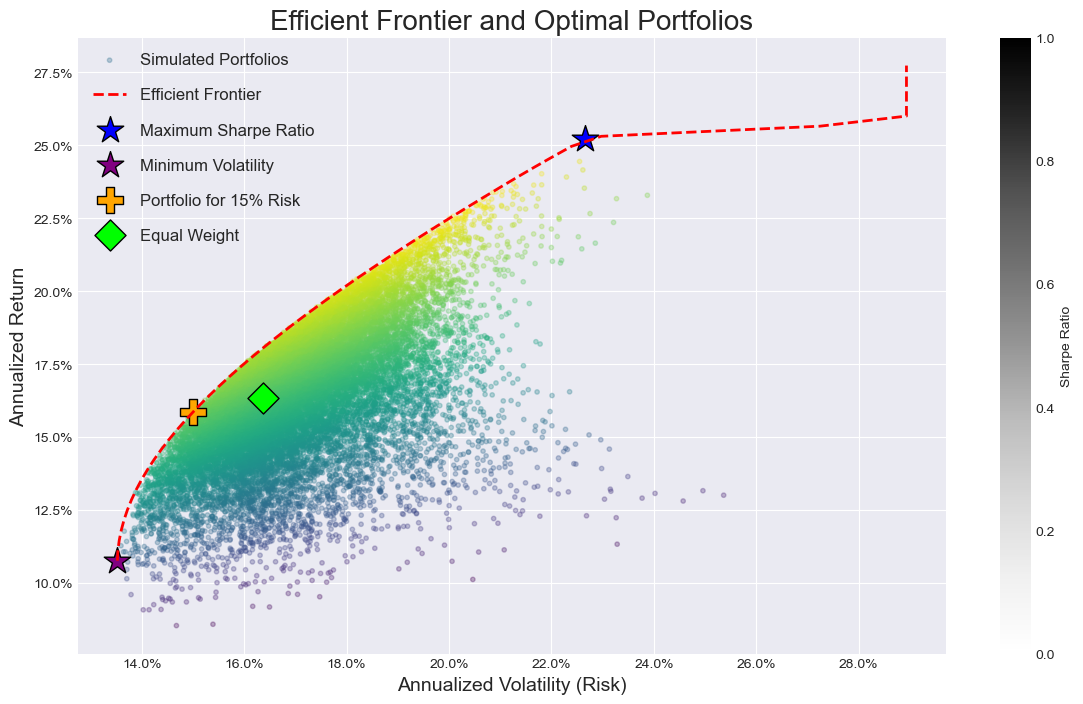

--- Weight Table of Key Portfolios ---
                          AAPL         JPM         JNJ         XOM         SPY
Maximum Sharpe       0.000000%   0.000000%  58.859871%   0.000000%  41.140129%
Minimum Volatility   0.000000%  49.889431%   0.000000%  42.165161%   7.945408%
Target Risk (15%)    0.000000%  30.124185%  19.147548%  30.969213%  19.759053%
Equal Weight        20.000000%  20.000000%  20.000000%  20.000000%  20.000000%

--- Metrics Table of Key Portfolios ---
                   Return Volatility Sharpe Ratio
Maximum Sharpe     25.21%     22.65%         0.93
Minimum Volatility 10.77%     13.52%         0.49
Target Risk (15%)  15.86%     15.00%         0.78
Equal Weight       16.35%     16.38%         0.74


In [24]:
# --- Calculation of the Equal Weight Portfolio (Benchmark) ---
equal_weights = np.array(len(tickers) * [1./len(tickers)])
equal_metrics = get_portfolio_metrics(equal_weights)

# --- Final Comparative Plot ---
plt.figure(figsize=(14, 8))

# 1. Scatter plot of the simulation
plt.scatter(simulated_portfolios['Volatility'], simulated_portfolios['Return'], c=simulated_portfolios['SharpeRatio'], cmap='viridis', marker='o', s=10, alpha=0.3, label='Simulated Portfolios')

# 2. Efficient Frontier curve
plt.plot(frontier_x, frontier_y, 'r--', linewidth=2, label='Efficient Frontier')

# 3. Optimal and benchmark portfolios
plt.scatter(sharpe_metrics[1], sharpe_metrics[0], marker='*', color='blue', s=400, edgecolors='black', label='Maximum Sharpe Ratio')
plt.scatter(vol_metrics[1], vol_metrics[0], marker='*', color='purple', s=400, edgecolors='black', label='Minimum Volatility')
plt.scatter(risk_metrics[1], risk_metrics[0], marker='P', color='orange', s=350, edgecolors='black', label=f'Portfolio for {target_risk:.0%} Risk')
plt.scatter(equal_metrics[1], equal_metrics[0], marker='D', color='lime', s=250, edgecolors='black', label='Equal Weight')

# Chart settings
plt.colorbar(label='Sharpe Ratio')
plt.title('Efficient Frontier and Optimal Portfolios', fontsize=20)
plt.xlabel('Annualized Volatility (Risk)', fontsize=14)
plt.ylabel('Annualized Return', fontsize=14)
plt.legend(labelspacing=1.2, fontsize=12)
plt.grid(True)

# --- Format Axes to Percentage ---
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.show()

# --- Creation of the Summary Table ---
data = {
    'Maximum Sharpe': sharpe_weights,
    'Minimum Volatility': vol_weights,
    f'Target Risk ({target_risk:.0%})': risk_weights,
    'Equal Weight': equal_weights
}
portfolios_table = pd.DataFrame(data, index=tickers)

metrics = pd.DataFrame({
    'Maximum Sharpe': sharpe_metrics,
    'Minimum Volatility': vol_metrics,
    f'Target Risk ({target_risk:.0%})': risk_metrics,
    'Equal Weight': equal_metrics
}, index=['Return', 'Volatility', 'Sharpe Ratio'])

print("--- Weight Table of Key Portfolios ---")
formatted_weights_table = portfolios_table.T.copy()
for col in formatted_weights_table.columns:
    formatted_weights_table[col] = formatted_weights_table[col].map('{:.6%}'.format)
print(formatted_weights_table.to_string())

print("\n--- Metrics Table of Key Portfolios ---")
print(metrics.T.to_string(formatters={'Return':'{:,.2%}'.format, 'Volatility':'{:,.2%}'.format, 'Sharpe Ratio':'{:,.2f}'.format}))

Excellent! You have completed the mathematical optimization phase. We have not only found the anchor portfolios with precision but also plotted the entire Efficient Frontier curve and created a custom portfolio. In the final phase, we will take the last step to introduce the risk-free asset and discover the Capital Market Line, the concept that unifies the entire theory.

## Phase 4: The Capital Market Line and the Investor's Final Decision

So far, we have operated in a universe of only risky assets. But in the real world, we have access to a **risk-free asset** (like U.S. T-Bills). The introduction of this asset completely changes the game.

The **Capital Market Line (CML)** represents this new and superior set of opportunities. It is a straight line that starts from the risk-free rate and is tangent to our Efficient Frontier. The point of tangency is, precisely, the **Maximum Sharpe Ratio portfolio**.

**Why is this so important?**

* **Superior Portfolios:** Any portfolio on the CML is **superior** to any portfolio on the Efficient Frontier (except for the tangency point). This means that portfolios that previously seemed "optimal," like the Minimum Volatility portfolio, now become **inefficient**.

* **The Best Risk-Return Trade-off:** The slope of the CML is the Sharpe Ratio of the tangency portfolio. Since the slope is constant, **all points on the CML have the same and highest possible Sharpe Ratio**. This represents the best "deal" an investor can get in the market.

* **New Investment Horizons:** The CML expands our options. For conservative investors, it allows creating portfolios with a risk **lower than the Minimum Volatility portfolio** (by combining T-Bills with the tangency portfolio) but with a higher return than the Efficient Frontier offered. For aggressive investors, the line extends beyond the tangency portfolio, theoretically representing **leveraged portfolios** where one could borrow at the risk-free rate to invest more than 100% of their capital.

### Step 4.1: The Superior Portfolio for Our Target Risk

Let's recall the portfolio we calculated in the previous phase for a specific risk level. That portfolio was on the Efficient Frontier. Now, we will calculate a new portfolio that has the exact **same risk level**, but is on the CML. We will see that for identical risk, we can get a higher return.

In [25]:
# --- Calculation of the Superior Portfolio on the CML ---
# CML Equation: Return = Risk-Free Rate + Volatility * Sharpe of the Tangency Portfolio
cml_target_return = risk_free_rate + target_risk * sharpe_metrics[2]

# --- Feedback for the user ---
print(f"--- Comparison for a Target Risk of {target_risk:.2%} ---")
print(f"Portfolio on the Efficient Frontier:")
print(f"  - Return: {risk_metrics[0]:.2%}")
print(f"Portfolio on the Capital Market Line (CML):")
print(f"  - Return: {cml_target_return:.2%}")
print(f"\nConclusion: For the same level of risk, the CML offers a superior return.")

--- Comparison for a Target Risk of 15.00% ---
Portfolio on the Efficient Frontier:
  - Return: 15.86%
Portfolio on the Capital Market Line (CML):
  - Return: 18.10%

Conclusion: For the same level of risk, the CML offers a superior return.


### Step 4.2: The Investor's Final Recipe

So, how is this superior CML portfolio constructed? The answer is the most elegant conclusion of the theory: it is a simple combination of the **risk-free asset** and the **tangency portfolio** (the one with the Maximum Sharpe Ratio).

We will calculate exactly what percentage of our capital should be allocated to each to achieve our target risk.

In [26]:
# --- Calculation of Weights on the CML ---
# The weight in the risky portfolio is the ratio of the target risk to the risk of the tangency portfolio
risky_weight = target_risk / sharpe_metrics[1]
risk_free_weight = 1 - risky_weight

# --- Breakdown of the Recipe for the Investor ---
print(f"\n--- Recipe for the Superior Portfolio with a Risk of {target_risk:.2%} ---")

# 1. The Strategic Decision
print("\n1. Strategic Decision (Capital Allocation):")
print(f"   - Invest {risk_free_weight:.2%} of capital in the Risk-Free Asset (e.g., T-Bills).")
print(f"   - Invest {risky_weight:.2%} of capital in the Maximum Sharpe Ratio Portfolio.")

# 2. Composition of the Risky Portfolio
print("\n2. Composition of the Maximum Sharpe Ratio Portfolio:")
for i, ticker in enumerate(tickers):
    print(f"   - {ticker}: {sharpe_weights[i]:.2%}")

# 3. Final Weighting on Total Capital
print("\n3. Final Weighting on your Total Capital:")
print(f"   - Risk-Free Asset: {risk_free_weight:.2%}")
for i, ticker in enumerate(tickers):
    effective_weight = sharpe_weights[i] * risky_weight
    print(f"   - {ticker}: {effective_weight:.2%}")


--- Recipe for the Superior Portfolio with a Risk of 15.00% ---

1. Strategic Decision (Capital Allocation):
   - Invest 33.77% of capital in the Risk-Free Asset (e.g., T-Bills).
   - Invest 66.23% of capital in the Maximum Sharpe Ratio Portfolio.

2. Composition of the Maximum Sharpe Ratio Portfolio:
   - AAPL: 0.00%
   - JPM: 0.00%
   - JNJ: 58.86%
   - XOM: 0.00%
   - SPY: 41.14%

3. Final Weighting on your Total Capital:
   - Risk-Free Asset: 33.77%
   - AAPL: 0.00%
   - JPM: 0.00%
   - JNJ: 38.98%
   - XOM: 0.00%
   - SPY: 27.25%


### Step 4.3: The Definitive Graph and Table

Finally, we create our master graph and summary table, which now include this new "Superior Portfolio on the CML," allowing for a complete visual and numerical comparison.

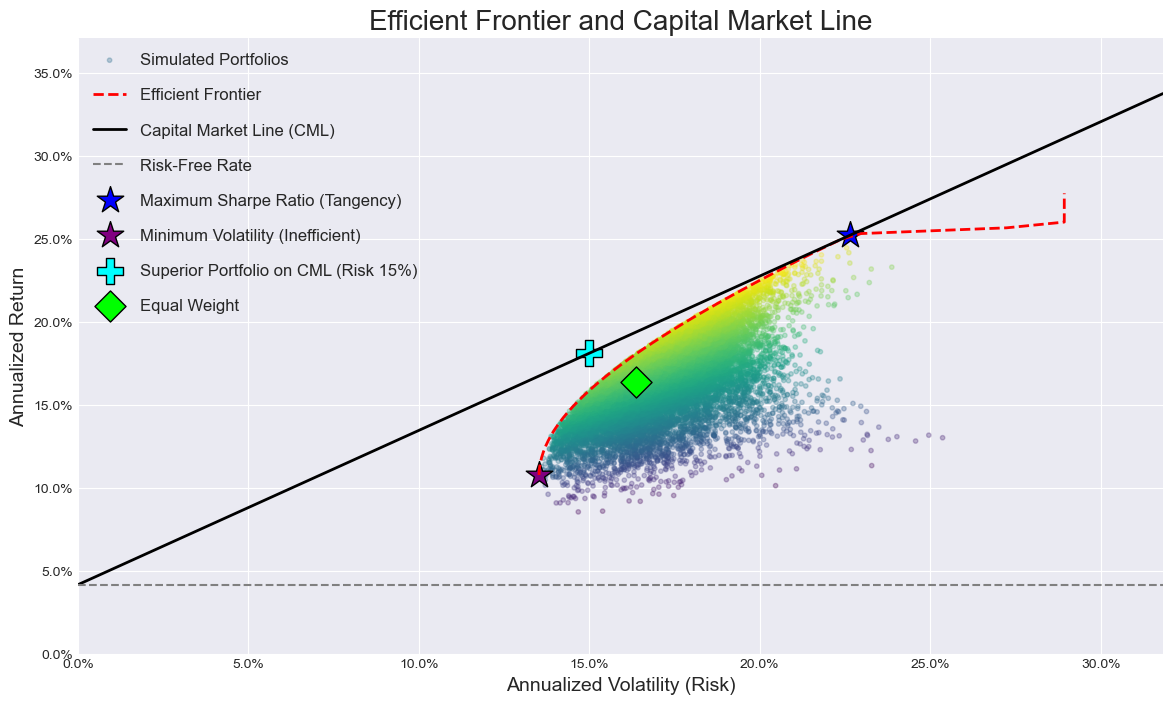

--- Weight Table of Key Portfolios ---
                          AAPL         JPM         JNJ         XOM         SPY
Maximum Sharpe       0.000000%   0.000000%  58.859871%   0.000000%  41.140129%
Minimum Volatility   0.000000%  49.889431%   0.000000%  42.165161%   7.945408%
Superior on CML      0.000000%   0.000000%  38.980771%   0.000000%  27.245625%
Equal Weight        20.000000%  20.000000%  20.000000%  20.000000%  20.000000%

--- Metrics Table of Key Portfolios ---
                   Return Volatility Sharpe Ratio
Maximum Sharpe     25.21%     22.65%         0.93
Minimum Volatility 10.77%     13.52%         0.49
Superior on CML    18.10%     15.00%         0.93
Equal Weight       16.35%     16.38%         0.74


In [27]:
# --- Calculation of the Capital Market Line (CML) ---
cml_x = np.linspace(0.0, max(frontier_x)*1.1, 100)
cml_y = risk_free_rate + cml_x * sharpe_metrics[2]

# --- Calculation of the Equal Weight Portfolio (Benchmark) ---
equal_weights = np.array(len(tickers) * [1./len(tickers)])
equal_metrics = get_portfolio_metrics(equal_weights)

# --- Final Comparative Plot ---
plt.figure(figsize=(14, 8))
plt.scatter(simulated_portfolios['Volatility'], simulated_portfolios['Return'], c=simulated_portfolios['SharpeRatio'], cmap='viridis', marker='o', s=10, alpha=0.3, label='Simulated Portfolios')
plt.plot(frontier_x, frontier_y, 'r--', linewidth=2, label='Efficient Frontier')
plt.plot(cml_x, cml_y, 'k-', linewidth=2, label='Capital Market Line (CML)')

# Horizontal line for the risk-free rate
plt.axhline(y=risk_free_rate, color='grey', linestyle='--', linewidth=1.5, label='Risk-Free Rate')

plt.scatter(sharpe_metrics[1], sharpe_metrics[0], marker='*', color='blue', s=400, edgecolors='black', label='Maximum Sharpe Ratio (Tangency)')
plt.scatter(vol_metrics[1], vol_metrics[0], marker='*', color='purple', s=400, edgecolors='black', label='Minimum Volatility (Inefficient)')
plt.scatter(target_risk, cml_target_return, marker='P', color='cyan', s=350, edgecolors='black', label=f'Superior Portfolio on CML (Risk {target_risk:.0%})')
plt.scatter(equal_metrics[1], equal_metrics[0], marker='D', color='lime', s=250, edgecolors='black', label='Equal Weight')
plt.title('Efficient Frontier and Capital Market Line', fontsize=20)
plt.xlabel('Annualized Volatility (Risk)', fontsize=14)
plt.ylabel('Annualized Return', fontsize=14)
plt.legend(labelspacing=1.2, fontsize=12)
plt.grid(True)
plt.axis([0, max(frontier_x)*1.1, 0, max(cml_y)*1.1]) # Adjust axes to start at 0
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

# --- Creation of the Summary Table ---
# We create the weights of the superior portfolio for the table
cml_weights = sharpe_weights * risky_weight
cml_metrics = np.array([cml_target_return, target_risk, (cml_target_return - risk_free_rate) / target_risk])

data = {
    'Maximum Sharpe': sharpe_weights,
    'Minimum Volatility': vol_weights,
    'Superior on CML': cml_weights,
    'Equal Weight': equal_weights
}
portfolios_table = pd.DataFrame(data, index=tickers)

metrics = pd.DataFrame({
    'Maximum Sharpe': sharpe_metrics,
    'Minimum Volatility': vol_metrics,
    'Superior on CML': cml_metrics,
    'Equal Weight': equal_metrics
}, index=['Return', 'Volatility', 'Sharpe Ratio'])

print("--- Weight Table of Key Portfolios ---")
formatted_weights_table = portfolios_table.T.copy()
for col in formatted_weights_table.columns:
    formatted_weights_table[col] = formatted_weights_table[col].map('{:.6%}'.format)
print(formatted_weights_table.to_string())

print("\n--- Metrics Table of Key Portfolios ---")
print(metrics.T.to_string(formatters={'Return':'{:,.2%}'.format, 'Volatility':'{:,.2%}'.format, 'Sharpe Ratio':'{:,.2f}'.format}))

You have successfully completed the analysis of the Capital Market Line. You've seen how introducing a risk-free asset redefines investment opportunities and have constructed the final 'recipe' for a superior portfolio. Now, we are ready to summarize our key findings in the final conclusions.

## Final Conclusions

Throughout this notebook, we have journeyed from raw market data to the construction of highly optimized investment portfolios.

The key takeaways we've learned are:

* **The Efficient Frontier** shows us the set of the best possible portfolios using only risky assets. Each point on the curve is optimal for a given level of risk.
* **The Capital Market Line (CML)** represents a higher level of optimization. By introducing a risk-free asset, we create a new set of portfolios (the straight line) that dominate almost all those on the Efficient Frontier.
* **The Mutual Fund Separation Theorem:** The existence of the CML leads to a powerful conclusion. All investors, regardless of their risk aversion, should invest in the same "fund" of risky assets: the **tangency portfolio** (our Maximum Sharpe Ratio portfolio). Then, each investor can adjust the total risk of their personal portfolio by deciding what percentage of their money to invest in this fund and what percentage in the risk-free asset.

It is crucial to remember that this model, while fundamental, is not without documented criticisms. Its assumptions, such as the normal distribution of returns or the stability of correlations, are often questioned in financial literature. For instance, a major theoretical limitation is that it assumes an investor can lend and borrow at the same risk-free rate, which is not realistic in practice. In response to these weaknesses, other models have emerged, such as the **Black-Litterman Model** or approaches based on minimizing `Conditional Value at Risk` (CVaR) instead of variance, which seek to address the limitations of the classic model.

Despite its limitations, Modern Portfolio Theory provides us with a robust and disciplined framework for making informed investment decisions, and this notebook serves as a solid foundation for exploring more advanced paths in the future.

I hope this journey through Modern Portfolio Theory has been very useful to you. The concepts I've explored here are the foundation of quantitative finance, and I invite you to continue delving into this fascinating field. Stay tuned for future notebooks where we will explore different models and other financial topics of interest.

***Thank you for joining me in this analysis!***

##  

<hr style="height:2px;border-width:0;color:blue;background-color:blue">
  <b>José Luis Cruz Balderas, CFA </b><br>
  <i>Business & Data Analyst | Strategy & Optimization</i><br>
      🌐 <a href="www.josecruz-finance.com"> josecruz-finance.com</a><br>
      📧 joseluis.cruz201102@gmail.com <br>
      📱 MX: +52 55 4649 4413 | 📱 CA: +1 236 514 9003 <br>   